# VECTOR AUTO-REGRESSION (VAR)

In SARIMAX models the exogenous variable affected the label variable but not the other way around. VAR models are used for a list of variables which can be hypothesized to affect each other inter-temporarily (VAR modeling does not require as much knowledge about forces affecting a variable as SARIMAX).

e.g. for VAR model application: forecasting changes in personal consumption expenditures $C_t$ using changes in personal disposable income $I_t$ (influence factor b/w the two could go both ways).

Systems of equations for a 2-dimensional VAR(1) model:

$y_1 = c_1 + \phi_{11,1} y_{1,t-1} + \phi_{12,1} y_{2,t-1} + \epsilon_{1,t}$\
$y_2 = c_1 + \phi_{21,1} y_{1,t-1} + \phi_{22,1} y_{2,t-1} + \epsilon_{2,t}$

Systems of equations for a 2-dimensional VAR(3) model:

$y_1 = c_1 + \phi_{11,1} y_{1,t-1} + \phi_{12,1} y_{2,t-1} + \phi_{11,2} y_{1,t-2} + \phi_{12,2} y_{2,t-2} + \phi_{11,3} y_{1,t-3} + \phi_{12,3} y_{2,t-3} +\epsilon_{1,t}$\
$y_2 = c_1 + \phi_{21,1} y_{1,t-1} + \phi_{22,1} y_{2,t-1} + \phi_{21,2} y_{1,t-2} + \phi_{22,2} y_{2,t-2} + \phi_{21,3} y_{1,t-3} + \phi_{22,3} y_{2,t-3} + \epsilon_{2,t}$

General steps involved in building a VAR model:
1. Examine the data
2. Visualize the data
3. Test for stationarity
4. Select the appropirate order p (can use something similar to auto_arima for that)
5. Instantiate the model and fit it to a training set
6. If necessary invert the transformation
7. Evaluate model predictions against a known test set
8. Forecast the future

**Datasets:** 2 datasets from FRED 
1. M2 Money Stock (saving deposits, small-denomination time deposit, balances in retail money market mutual funds)
2. Personal Consumption Expenditures

From intuition, it seems that there should be some sort of relationship between the two time series. => Ideal for VAR models.\
We can use a 2-dimensional VAR(1) model with:\
$y_1$ = Personal Consumption Expenditures\
$y_2$ = M2 Money Stock

In [19]:
import numpy as np
import pandas as pd
%matplotlib inline

# Load specific forecasting tools
from statsmodels.tsa.api import VAR,VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

# Load datasets
df = pd.read_csv('../Data/M2SLMoneyStock.csv',index_col=0, parse_dates=True)
df.index.freq = 'MS'

sp = pd.read_csv('../Data/PCEPersonalSpending.csv',index_col=0, parse_dates=True)
sp.index.freq = 'MS'

In [20]:
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [21]:
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [22]:
# joining the two datasets
df = df.join(sp)
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


In [23]:
df = df.dropna()

<AxesSubplot:xlabel='Date'>

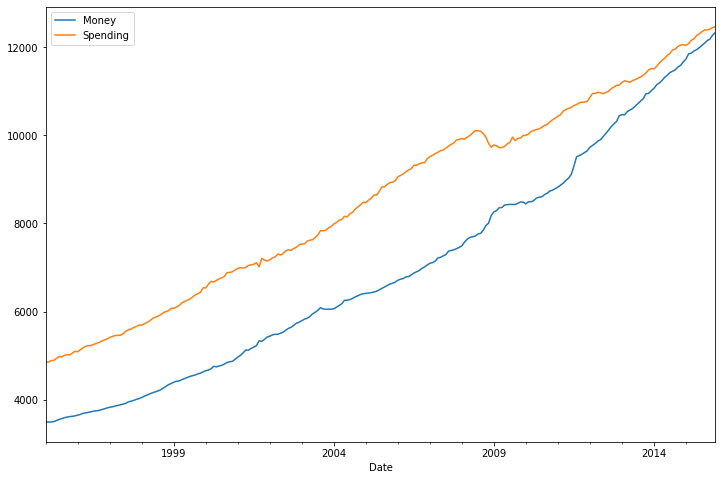

In [24]:
df.plot(figsize=(12,8))

### test for stationarity

In [25]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [26]:
adf_test(df['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic        4.239022
p-value                   1.000000
# lags used               4.000000
# observations          247.000000
critical value (1%)      -3.457105
critical value (5%)      -2.873314
critical value (10%)     -2.573044
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [27]:
adf_test(df['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic        0.149796
p-value                   0.969301
# lags used               3.000000
# observations          248.000000
critical value (1%)      -3.456996
critical value (5%)      -2.873266
critical value (10%)     -2.573019
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


So, neither variable is stationary.

In [28]:
# differencing using pandas

df_transformed = df.diff()
df_transformed.head()

,Money,Spending
Date,,
1995-01-01,NaN,NaN
1995-02-01,-2.5,-0.4
1995-03-01,1.2,34.6
1995-04-01,8.1,4.8
1995-05-01,25.0,42.9


In [29]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic       -2.057404
p-value                   0.261984
# lags used              15.000000
# observations          235.000000
critical value (1%)      -3.458487
critical value (5%)      -2.873919
critical value (10%)     -2.573367
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [30]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.226974e+00
p-value                 2.041027e-10
# lags used             2.000000e+00
# observations          2.480000e+02
critical value (1%)    -3.456996e+00
critical value (5%)    -2.873266e+00
critical value (10%)   -2.573019e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


so Money column is still non-stationary even after first differencing.

We will have to apply a second order differencing to both columns.

In [31]:
df_transformed = df_transformed.diff().dropna()
df_transformed.head()

,Money,Spending
Date,,
1995-03-01,3.7,35.0
1995-04-01,6.9,-29.8
1995-05-01,16.9,38.1
1995-06-01,-0.3,1.5
1995-07-01,-6.2,-51.7


In [32]:
adf_test(df_transformed['Money'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -7.077471e+00
p-value                 4.760675e-10
# lags used             1.400000e+01
# observations          2.350000e+02
critical value (1%)    -3.458487e+00
critical value (5%)    -2.873919e+00
critical value (10%)   -2.573367e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


In [33]:
adf_test(df_transformed['Spending'])

Augmented Dickey-Fuller Test: 
ADF test statistic     -8.760145e+00
p-value                 2.687900e-14
# lags used             8.000000e+00
# observations          2.410000e+02
critical value (1%)    -3.457779e+00
critical value (5%)    -2.873609e+00
critical value (10%)   -2.573202e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


So both columns are stationary after second differencing.

In [35]:
# train-test split
# keeping the last one year for test
nobs = 12
train = df_transformed[:-nobs]
test = df_transformed[-nobs:]

### Grid Search for order p of AR of the VAR model

In [36]:
model = VAR(train)
for p in range(1,8):
    results = model.fit(p)
    print(f'ORDER {p}')
    print(f'AIC : {results.aic}')
    print('\n')

ORDER 1
AIC : 14.178610495220896


ORDER 2
AIC : 13.955189367163705


ORDER 3
AIC : 13.849518291541038


ORDER 4
AIC : 13.827950574458281


ORDER 5
AIC : 13.78730034460964


ORDER 6
AIC : 13.799076756885809


ORDER 7
AIC : 13.797638727913972




Lowest AIC value found for order p=5

In [37]:
results = model.fit(5)
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 16, Dec, 2020
Time:                     14:07:44
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                    14.1131
Nobs:                     233.000    HQIC:                   13.9187
Log likelihood:          -2245.45    FPE:                    972321.
AIC:                      13.7873    Det(Omega_mle):         886628.
--------------------------------------------------------------------
Results for equation Money
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.516683         1.782238            0.290           0.772
L1.Money           -0.646232         0.068177           -9.479           0.000
L1.Spending        -0.107411         0.051388           -2.090      

## making predictions

In [39]:
# Grab the last 5 lagged values right before the test starts
lagged_values = train.values[-5:]

In [40]:
z = results.forecast(y=lagged_values,steps=12) # these will still be 2nd difference values

In [41]:
idx = pd.date_range('2015-01-01',periods=12,freq='MS') # our test-set starts from '2015-01-01'

In [42]:
df_forecast = pd.DataFrame(data=z,index=idx,columns=['Money_2d','Spending_2d']) # 2d -> differenced twice

In [43]:
df_forecast

,Money_2d,Spending_2d
2015-01-01,-16.995276,36.149820
2015-02-01,-3.174038,-11.450298
2015-03-01,-0.377725,-6.684969
2015-04-01,-2.602233,5.479458
2015-05-01,4.228557,-2.443365
2015-06-01,1.559393,0.387639
2015-07-01,-0.998410,3.883680
2015-08-01,0.364510,-2.356101
2015-09-01,-1.210627,-1.224147
2015-10-01,0.225877,0.786927


## Invert the transforms (reversing the differences)

In [45]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_forecast['Money_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_forecast['Money1d'].cumsum()

In [46]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_forecast['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_forecast['Spending_2d'].cumsum()

# Now build the forecast values from the first difference set
df_forecast['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_forecast['Spending1d'].cumsum()

In [47]:
df_forecast

,Money_2d,Spending_2d,Money1d,MoneyForecast,Spending1d,SpendingForecast
2015-01-01,-16.995276,36.149820,61.604724,11731.704724,46.749820,12108.749820
2015-02-01,-3.174038,-11.450298,58.430686,11790.135410,35.299522,12144.049342
2015-03-01,-0.377725,-6.684969,58.052961,11848.188371,28.614552,12172.663894
2015-04-01,-2.602233,5.479458,55.450728,11903.639099,34.094010,12206.757904
2015-05-01,4.228557,-2.443365,59.679285,11963.318384,31.650645,12238.408549
2015-06-01,1.559393,0.387639,61.238678,12024.557062,32.038284,12270.446833
2015-07-01,-0.998410,3.883680,60.240268,12084.797331,35.921964,12306.368797
2015-08-01,0.364510,-2.356101,60.604779,12145.402109,33.565863,12339.934659
2015-09-01,-1.210627,-1.224147,59.394151,12204.796261,32.341716,12372.276375
2015-10-01,0.225877,0.786927,59.620028,12264.416289,33.128643,12405.405019


In [48]:
test_range = df[-nobs:] # taking the test values from the original data set

<AxesSubplot:>

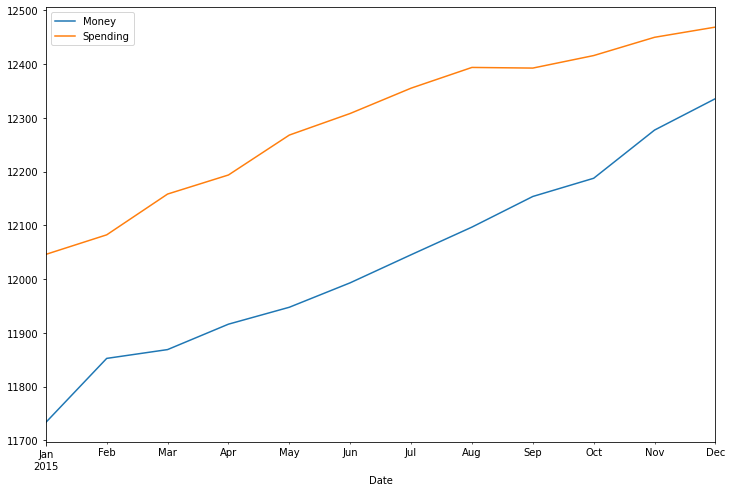

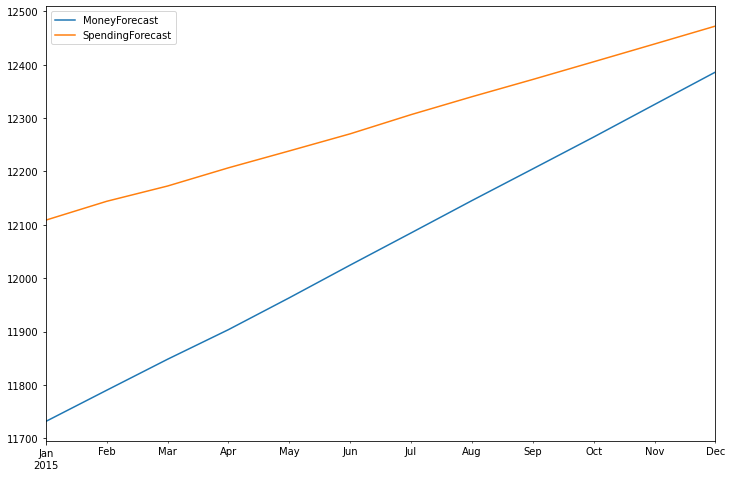

In [50]:
test_range.plot(figsize=(12,8))
df_forecast[['MoneyForecast','SpendingForecast']].plot(figsize=(12,8))

<AxesSubplot:xlabel='Date'>

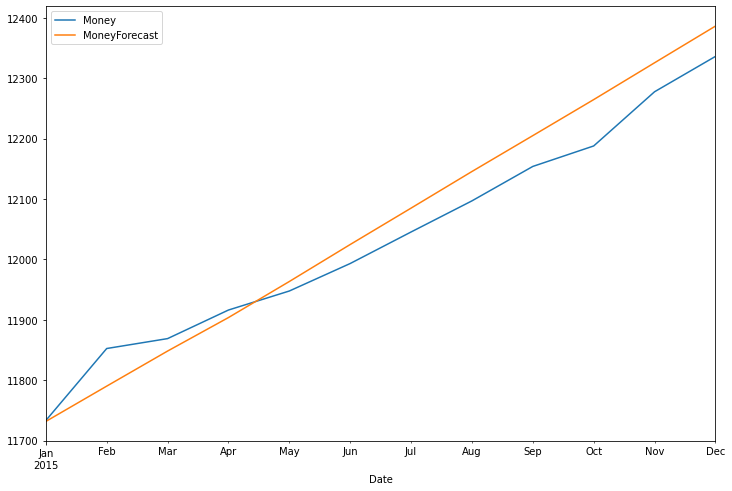

In [51]:
test_range['Money'].plot(figsize=(12,8),legend=True)
df_forecast['MoneyForecast'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

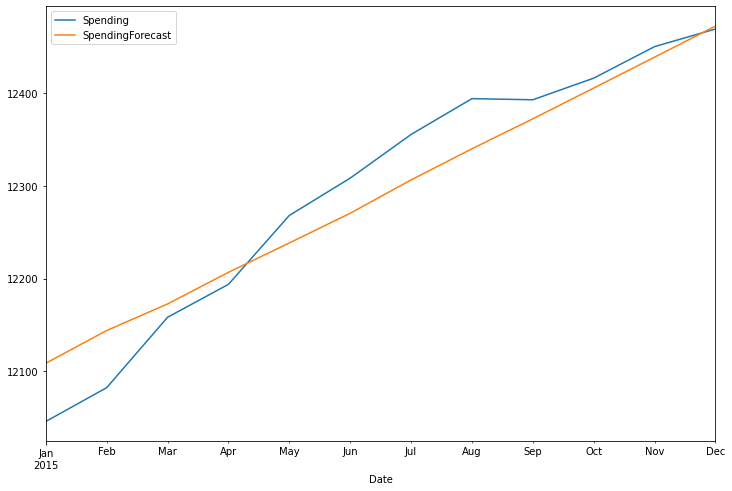

In [52]:
test_range['Spending'].plot(figsize=(12,8),legend=True)
df_forecast['SpendingForecast'].plot(legend=True)

## Evaluating the predictions

In [54]:
error_money = rmse(test_range['Money'],df_forecast['MoneyForecast'])
mean_money_value = test_range['Money'].mean()
print(error_money,error_money/mean_money_value)

43.71049653558893 0.0036322474876898676


In [55]:
error_spending = rmse(test_range['Spending'],df_forecast['SpendingForecast'])
mean_spending_value = test_range['Spending'].mean()
print(error_spending,error_spending/mean_spending_value)

37.001175169408285 0.0030095632071767625
